## Cargando dependencias y dataset [Stanford Dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs?hl=es-419)

In [1]:
! pip install keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 19.8 MB/s eta 0:00:00


In [2]:
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds

(train_dataset, test_dataset), info = tfds.load(
    "stanford_dogs", split=["train", "test"], as_supervised=True, with_info=True
)

Using TensorFlow backend


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteZ6SIF5/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteZ6SIF5/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [3]:
n_classes = info.features["label"].num_classes
class_names = [name.split("-")[1] for name in info.features["label"].names]
class_names

['chihuahua',
 'japanese_spaniel',
 'maltese_dog',
 'pekinese',
 'shih',
 'blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'rhodesian_ridgeback',
 'afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black',
 'walker_hound',
 'english_foxhound',
 'redbone',
 'borzoi',
 'irish_wolfhound',
 'italian_greyhound',
 'whippet',
 'ibizan_hound',
 'norwegian_elkhound',
 'otterhound',
 'saluki',
 'scottish_deerhound',
 'weimaraner',
 'staffordshire_bullterrier',
 'american_staffordshire_terrier',
 'bedlington_terrier',
 'border_terrier',
 'kerry_blue_terrier',
 'irish_terrier',
 'norfolk_terrier',
 'norwich_terrier',
 'yorkshire_terrier',
 'wire',
 'lakeland_terrier',
 'sealyham_terrier',
 'airedale',
 'cairn',
 'australian_terrier',
 'dandie_dinmont',
 'boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'scotch_terrier',
 'tibetan_terrier',
 'silky_terrier',
 'soft',
 'west_highland_white_terrier',
 'lhasa',
 'flat',
 'curly',
 'golden_retriever',


## Visualizando ejemplos

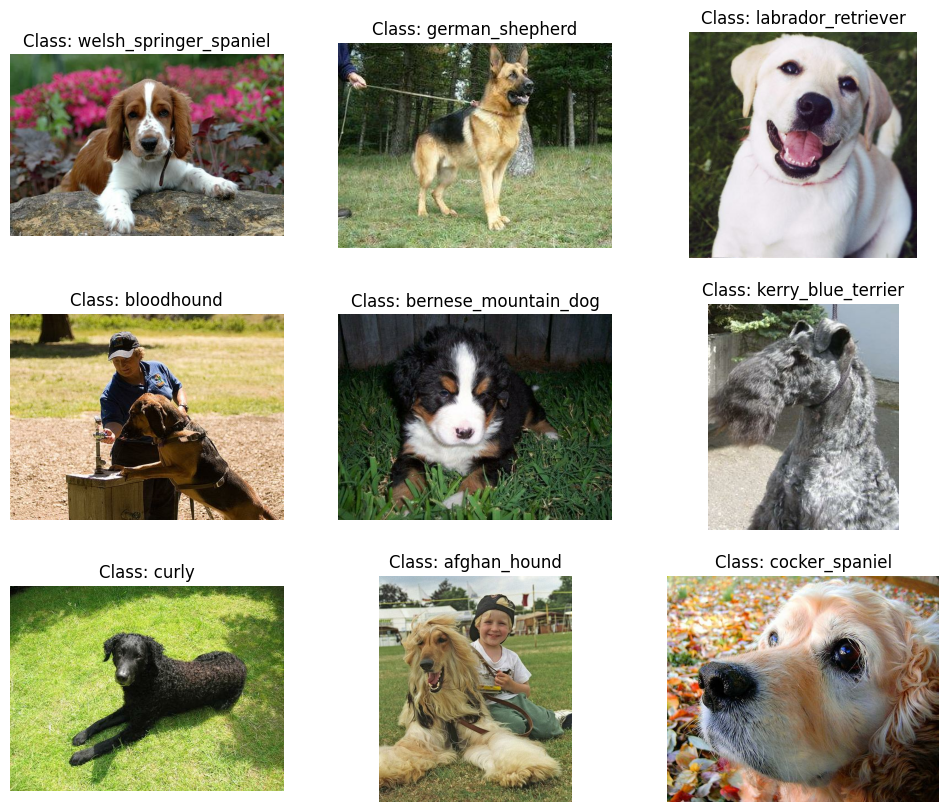

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
index = 0
for image, label in test_dataset.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

## Data augmentation

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32


resize = keras_cv.layers.Resizing(
    224, 224, crop_to_aspect_ratio=True
)

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255
    return resize(image), label

train_data = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(1000, seed=42).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_data = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

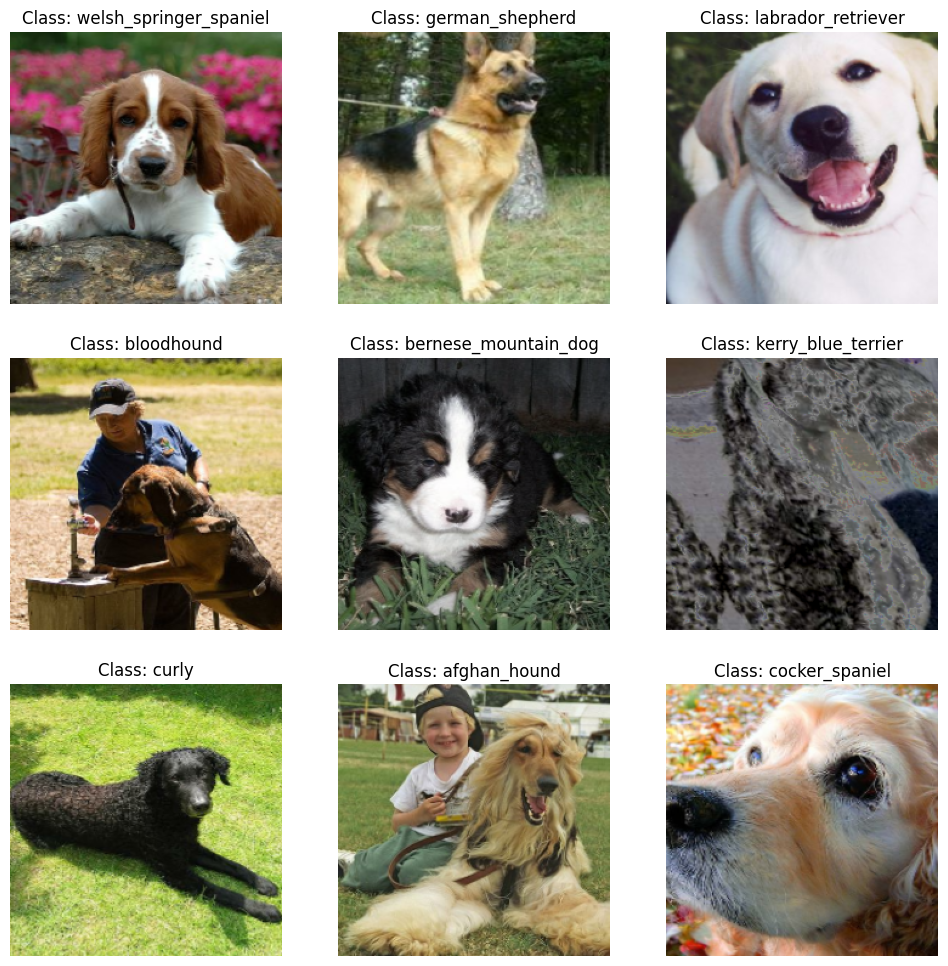

In [6]:
data_augmentation = keras.Sequential([
    keras_cv.layers.RandomFlip(),
    keras_cv.layers.RandomCropAndResize(
        target_size=(224, 224),
        crop_area_factor=(0.6, 1),
        aspect_ratio_factor=(0.8, 1)
    ),
    keras_cv.layers.RandAugment(value_range=(0, 1), magnitude=0.3, rate=0.3)
])


plt.figure(figsize=(12, 12))
for image_batch, label in test_data.take(1):
    image_batch = data_augmentation(image_batch, training=True)

    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(image_batch[index])
        plt.title(f"Class: {class_names[label[index]]}")
        plt.axis("off")

plt.show()

In [7]:
train_data_augmented = train_data.map(lambda X, y: (data_augmentation(X), y), num_parallel_calls=tf.data.AUTOTUNE)

## Construcción del modelo para Transfer learning

In [8]:
model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_s_imagenet",
    num_classes=n_classes
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[keras.metrics.TopKCategoricalAccuracy(k=3), "accuracy"]
)

# Congelamos la capa que contiene el modelo base
model.layers[1].trainable = False

model.summary()

81966128/81966128 [==============================] - 3s 0us/step
Model: "image_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 efficient_net_v2_backbone   (None, None, None, 1280   20331360  
 (EfficientNetV2Backbone)    )                                   
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 predictions (Dense)         (None, 120)               153720    
                                                                 
Total params: 20485080 (78.14 MB)
Trainable params: 153720 (600.47 KB)
Non-trainable params: 20331360 (77.56 MB)
____

## Entrenamiento del modelo

In [9]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25,
)

Epoch 1/25
375/375 [==============================] - 331s 613ms/step - loss: 2.5817 - top_k_categorical_accuracy: 0.0221 - accuracy: 0.3328 - val_loss: 1.9090 - val_top_k_categorical_accuracy: 0.0143 - val_accuracy: 0.4607
Epoch 2/25
375/375 [==============================] - 231s 610ms/step - loss: 1.5927 - top_k_categorical_accuracy: 0.0258 - accuracy: 0.5392 - val_loss: 1.5632 - val_top_k_categorical_accuracy: 0.0508 - val_accuracy: 0.5561
Epoch 3/25
375/375 [==============================] - 231s 612ms/step - loss: 1.2855 - top_k_categorical_accuracy: 0.0288 - accuracy: 0.6121 - val_loss: 1.8984 - val_top_k_categorical_accuracy: 0.0332 - val_accuracy: 0.5117
Epoch 4/25
375/375 [==============================] - 230s 609ms/step - loss: 1.0846 - top_k_categorical_accuracy: 0.0290 - accuracy: 0.6621 - val_loss: 1.9040 - val_top_k_categorical_accuracy: 0.0273 - val_accuracy: 0.5174
Epoch 5/25
375/375 [==============================] - 230s 609ms/step - loss: 0.9307 - top_k_categorical

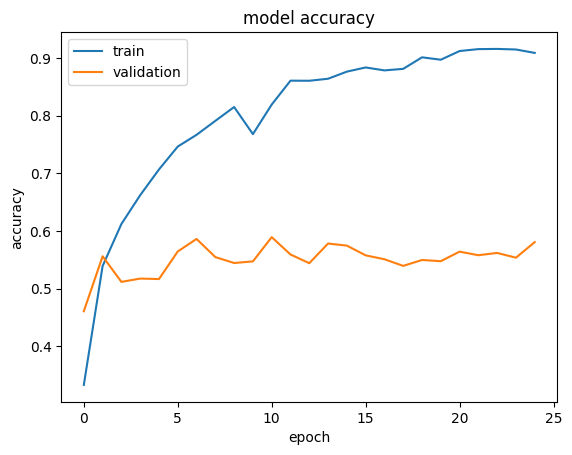

In [10]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

Epoch 1/10
375/375 [==============================] - 315s 828ms/step - loss: 1.4656 - top_k_categorical_accuracy: 0.0281 - accuracy: 0.6208 - val_loss: 1.6729 - val_top_k_categorical_accuracy: 0.0368 - val_accuracy: 0.5950
Epoch 2/10
375/375 [==============================] - 309s 818ms/step - loss: 1.0295 - top_k_categorical_accuracy: 0.0290 - accuracy: 0.7112 - val_loss: 1.6825 - val_top_k_categorical_accuracy: 0.0269 - val_accuracy: 0.6056
Epoch 3/10
375/375 [==============================] - 300s 793ms/step - loss: 0.8774 - top_k_categorical_accuracy: 0.0347 - accuracy: 0.7489 - val_loss: 1.6059 - val_top_k_categorical_accuracy: 0.0272 - val_accuracy: 0.6129
Epoch 4/10
375/375 [==============================] - 299s 791ms/step - loss: 0.8190 - top_k_categorical_accuracy: 0.0312 - accuracy: 0.7556 - val_loss: 1.6840 - val_top_k_categorical_accuracy: 0.0142 - val_accuracy: 0.6075
Epoch 5/10
375/375 [==============================] - 300s 792ms/step - loss: 0.7608 - top_k_categorical

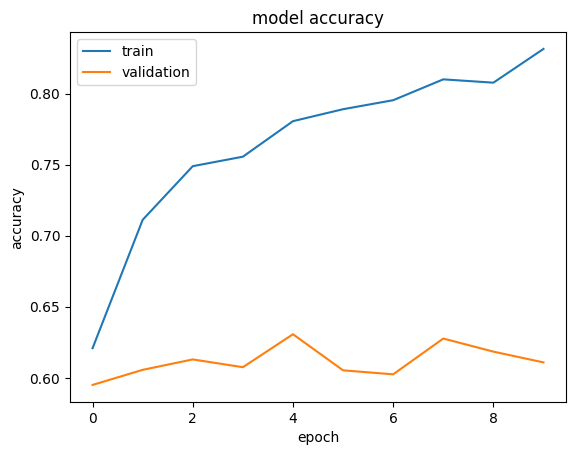

In [13]:
history_augmented = model.fit(
    train_data_augmented,
    validation_data=test_data,
    epochs=10,
)

plot_hist(history_augmented)

### Fine-tuning

Epoch 1/5
375/375 [==============================] - 405s 821ms/step - loss: 0.4780 - top_k_categorical_accuracy: 0.0421 - accuracy: 0.8597 - val_loss: 1.5316 - val_top_k_categorical_accuracy: 0.0386 - val_accuracy: 0.6552
Epoch 2/5
375/375 [==============================] - 302s 799ms/step - loss: 0.3769 - top_k_categorical_accuracy: 0.0408 - accuracy: 0.8864 - val_loss: 1.4643 - val_top_k_categorical_accuracy: 0.0361 - val_accuracy: 0.6705
Epoch 3/5
375/375 [==============================] - 300s 794ms/step - loss: 0.3333 - top_k_categorical_accuracy: 0.0372 - accuracy: 0.9007 - val_loss: 1.4262 - val_top_k_categorical_accuracy: 0.0330 - val_accuracy: 0.6779
Epoch 4/5
375/375 [==============================] - 298s 789ms/step - loss: 0.3303 - top_k_categorical_accuracy: 0.0377 - accuracy: 0.9037 - val_loss: 1.3995 - val_top_k_categorical_accuracy: 0.0290 - val_accuracy: 0.6829
Epoch 5/5
375/375 [==============================] - 299s 791ms/step - loss: 0.2925 - top_k_categorical_accu

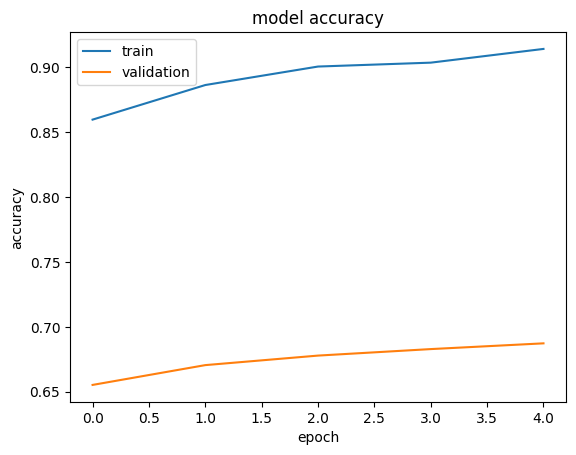

In [15]:
# Descongelamos la capa del modelo base
model.layers[1].trainable = True

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[keras.metrics.TopKCategoricalAccuracy(k=3), "accuracy"]
)

history_finetuned = model.fit(
    train_data_augmented,
    validation_data=test_data,
    epochs=5,
)

plot_hist(history_finetuned)

### Entrenamiento con el resto de los datos

Epoch 1/3
269/269 [==============================] - 140s 521ms/step - loss: 1.3305 - top_k_categorical_accuracy: 0.0348 - accuracy: 0.6767
Epoch 2/3
269/269 [==============================] - 142s 528ms/step - loss: 1.1823 - top_k_categorical_accuracy: 0.0307 - accuracy: 0.6909
Epoch 3/3
269/269 [==============================] - 144s 536ms/step - loss: 1.0884 - top_k_categorical_accuracy: 0.0295 - accuracy: 0.7031


KeyError: ignored

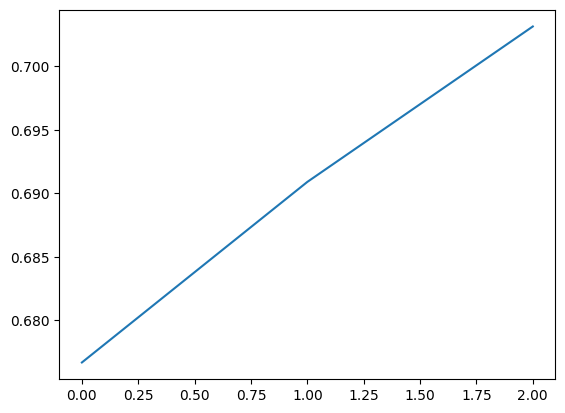

In [19]:
history_final = model.fit(
    test_data,
    epochs=3,
)

plot_hist(history_final)

## Exportando el modelo

In [20]:
model.export("img_clasif" )

Saved artifact at 'img_clasif'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, None, None, 3)
  Returns:
    float32 Tensor, shape=(None, 120)


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
! cp -r 'img_clasif' 'drive/MyDrive/img_clasif'